In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pymc as pm
from quap import quap
import arviz as az
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
df = df[df.age >= 18]
df.head()
i = 0

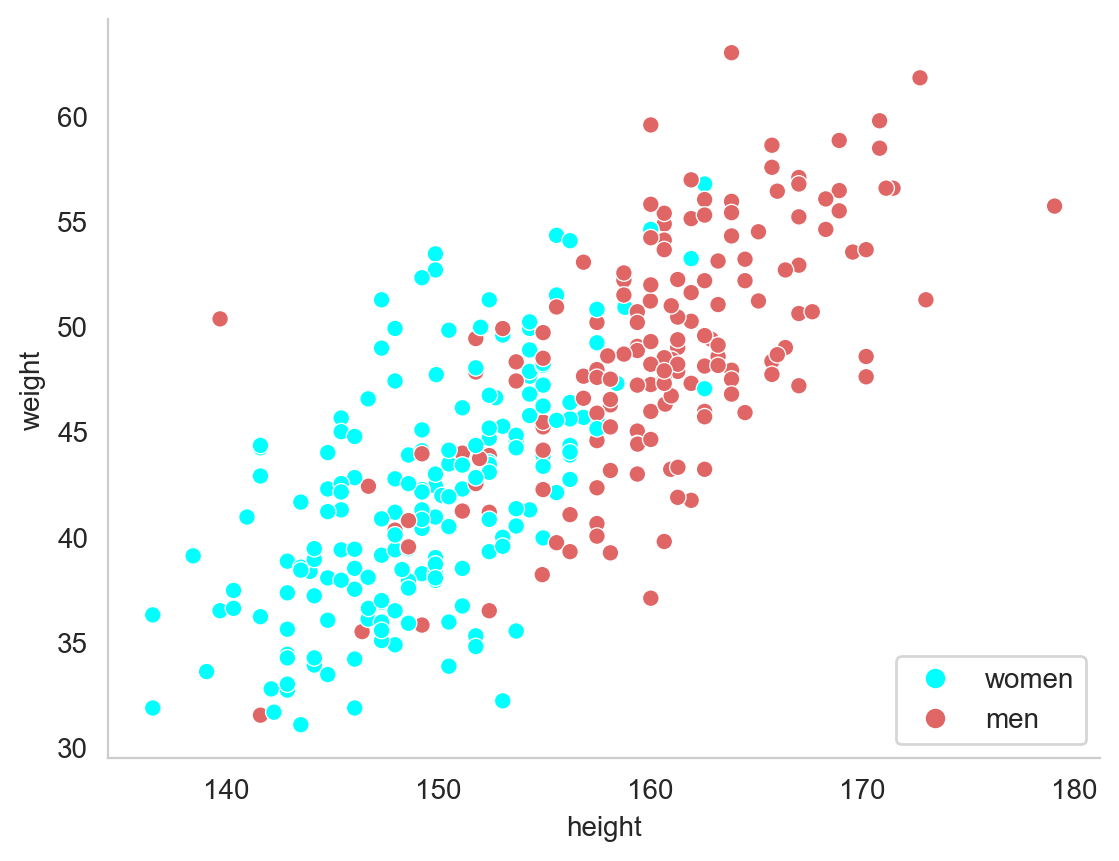

In [3]:
ax = sns.scatterplot(data=df, x='height', y='weight', hue='male', palette=["cyan", "#e06666"])

custom = [Line2D([], [], marker='o', color='cyan', linestyle='None'),
          Line2D([], [], marker='o', color='#e06666', linestyle='None')]

plt.legend(custom, ['women', 'men'], loc='lower right')
sns.despine()
plt.grid(False)
plt.show()

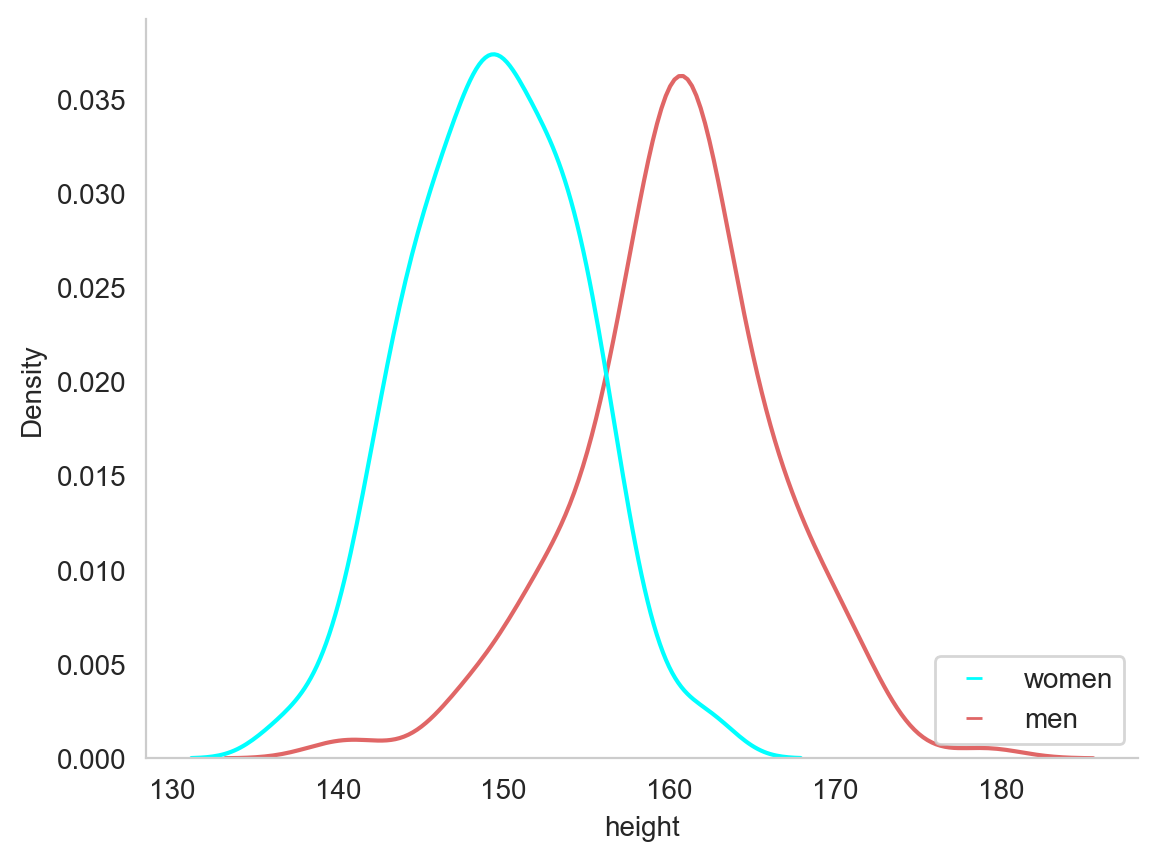

In [4]:
ax = sns.kdeplot(data=df, x='height', hue='male', palette=["cyan", "#e06666"])
custom = [Line2D([], [], marker='_', color='cyan', linestyle='None'),
          Line2D([], [], marker='_', color='#e06666', linestyle='None')]

plt.legend(custom, ['women', 'men'], loc='lower right')
sns.despine()
plt.grid(False)

## Total causal effect of gender on weight

$\alpha = [\alpha_0, \alpha_1]$, $\alpha_i \sim Normal(60, 10)$  
$W \sim Normal (\alpha_i, \mu)$

### Posterior mean weight by gender

In [5]:
df = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
df = df[df.age >= 18]
gen = df.male

with pm.Model() as model:
    a = pm.Normal('a', 60, 10, shape=2)  # need 2 alphas in model
    mu = pm.Deterministic("mu", a[gen])
    sigma = pm.Uniform("sigma", 0, 10)
    weight = pm.Normal("weight", mu, sigma, observed=df.weight)
    
    idata, posterior = quap([a, sigma])

In [6]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a[0],41.844,0.400,41.098,42.607
a[1],48.610,0.427,47.833,49.433
sigma,5.490,0.084,5.329,5.644


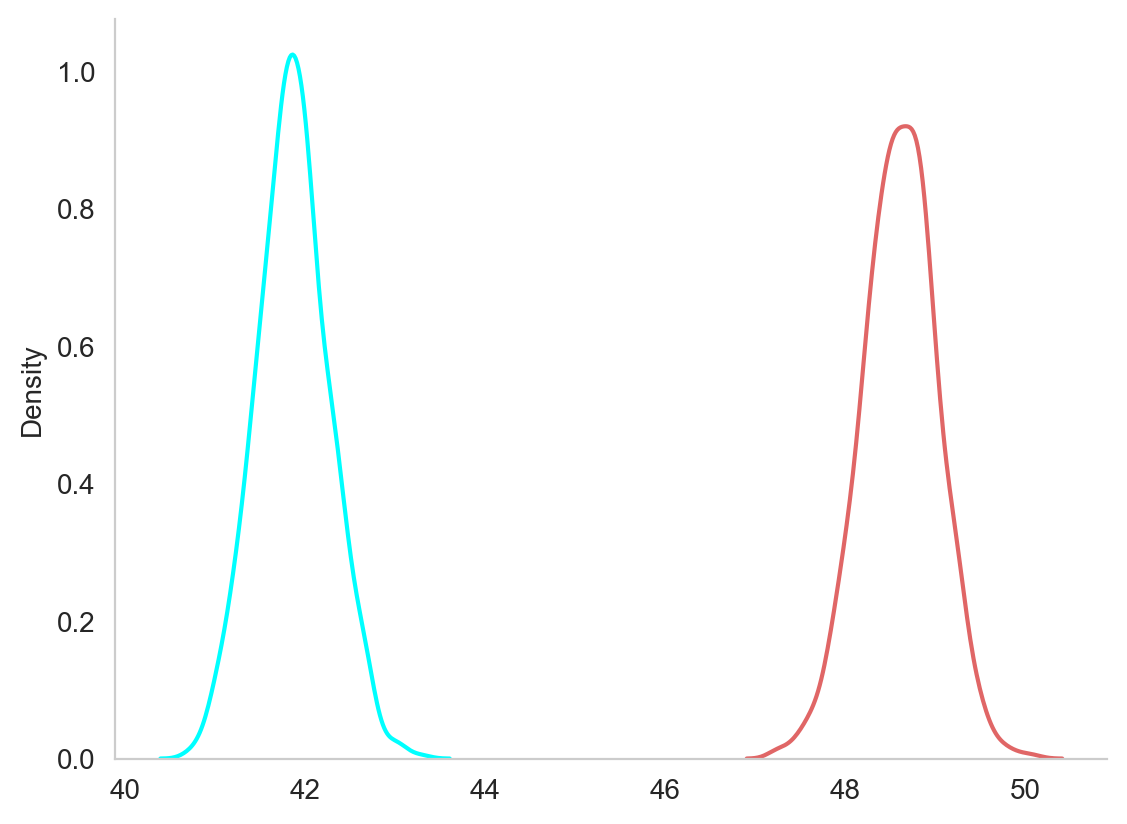

In [7]:
post_sample = az.extract(idata, num_samples=1000)

sns.kdeplot(post_sample.a.values[1], color = '#e06666')
ax = sns.kdeplot(post_sample.a.values[0], color='cyan')
sns.despine()
plt.grid(False)

### Posterior predicted weight by gender

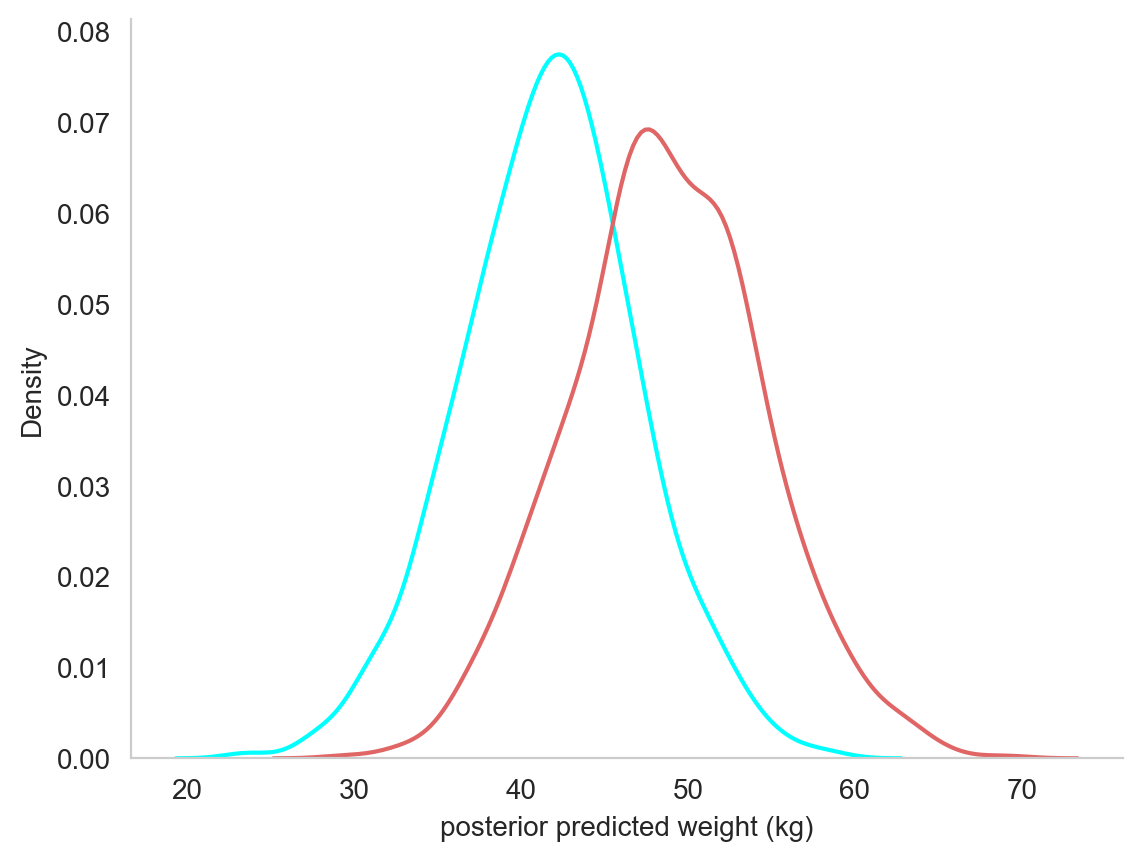

In [8]:
weight_w = stats.norm.rvs(post_sample.a.values[0], post_sample.sigma.values)
weight_m = stats.norm.rvs(post_sample.a.values[1], post_sample.sigma.values)

sns.kdeplot(weight_w, color='cyan')
ax = sns.kdeplot(weight_m, color='#e06666')
ax.set_xlabel("posterior predicted weight (kg)")
sns.despine()
plt.grid(False)

In [9]:
post_sample

<xarray.Dataset>
Dimensions:  (a_dim_0: 2, sample: 1000)
Coordinates:
  * a_dim_0  (a_dim_0) int32 0 1
  * sample   (sample) object MultiIndex
  * chain    (sample) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int32 8320 156 9321 2594 3404 ... 9173 8133 577 9427 3703
Data variables:
    a        (a_dim_0, sample) float64 41.36 41.42 41.62 ... 48.79 48.86 49.18
    sigma    (sample) float64 5.47 5.488 5.512 5.497 ... 5.5 5.536 5.394 5.429
Attributes:
    created_at:     2024-02-16T04:44:25.629940
    arviz_version:  0.17.0

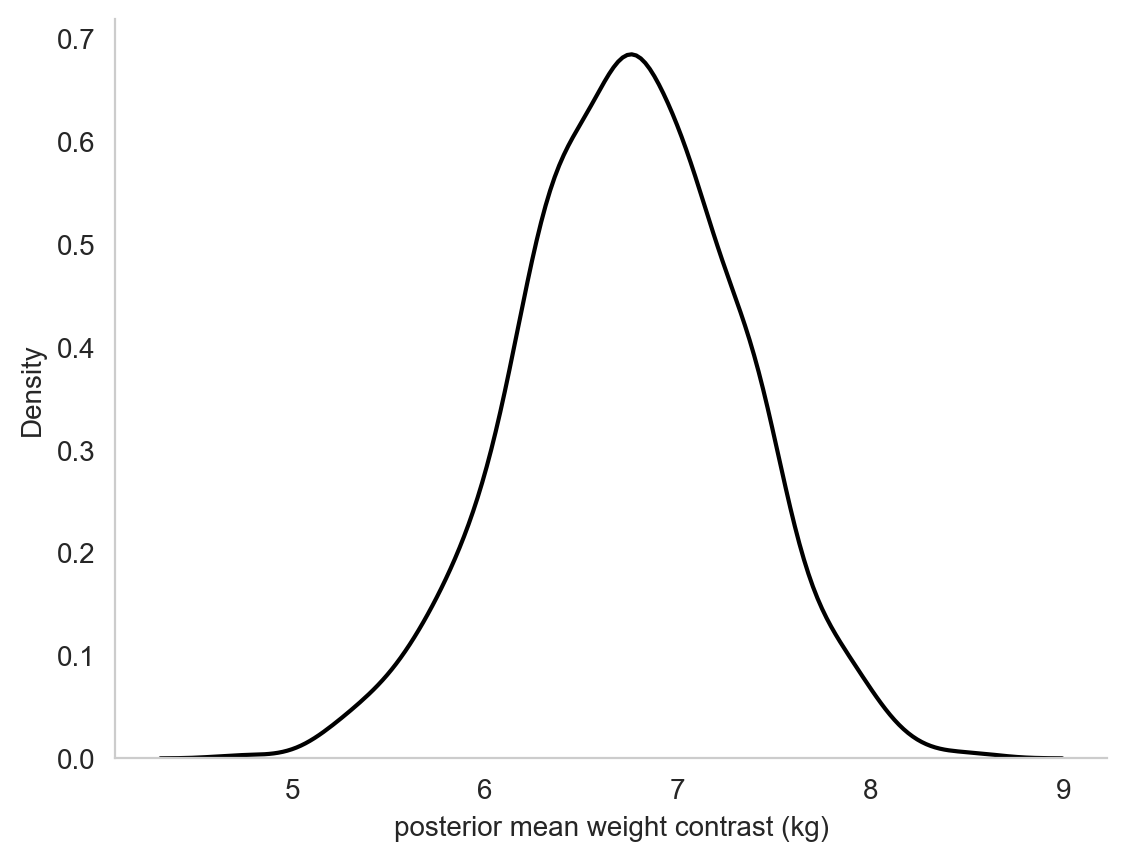

In [10]:
mu_contrast = post_sample.a.values[1] - post_sample.a.values[0]
sns.kdeplot(mu_contrast, color='black').set_xlabel("posterior mean weight contrast (kg)")
sns.despine()
plt.grid(False)

In [11]:
def filled_contrast_dist(w_contrast):
    kde = stats.gaussian_kde(w_contrast)
    # plot complete kde curve as line
    pos = np.linspace(w_contrast.min(), w_contrast.max(), 101)
    plt.plot(pos, kde(pos), color="black")
    # plot shaded kde only right of x=0
    shade_M = np.linspace(0, w_contrast.max(), 101)
    plt.fill_between(shade_M, kde(shade_M), color="#e06666")

    # plot shaded kde only left of x=0
    shade_W = np.linspace(w_contrast.min(), 0, 101)
    plt.fill_between(shade_W, kde(shade_W), color="cyan")

    # proportion above 0
    prop_above = sum(w_contrast > 0) / w_contrast.size

    # proportion below 0
    prop_below = sum(w_contrast < 0) / w_contrast.size

    plt.xlabel("posterior weight contrast (kg)")
    plt.ylabel("Density")
    plt.grid(False)
    sns.despine()
    print(f"[{prop_below},{prop_above}]")

[0.196,0.804]


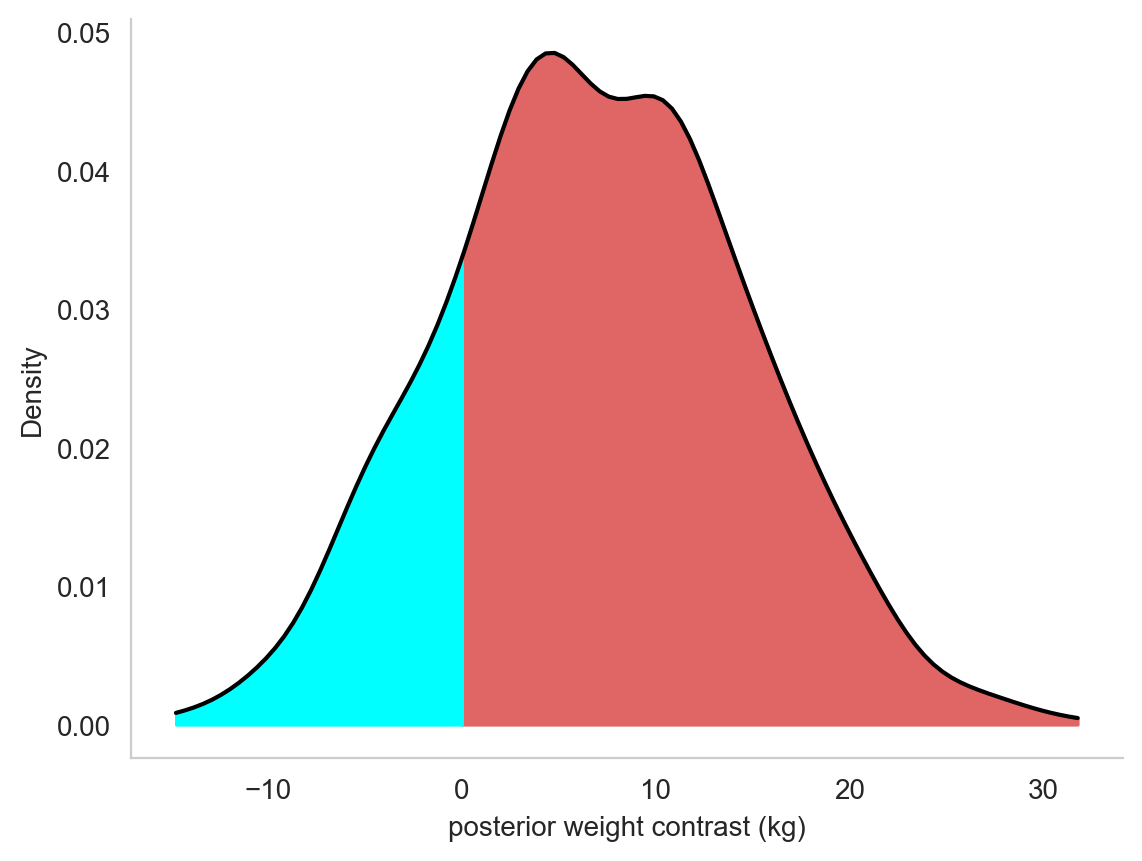

In [12]:
w_contrast = weight_m - weight_w
filled_contrast_dist(w_contrast)

## Direct causal effect of gender on weight

### model without stratification by gender
$W_i \sim Normal(\mu_i, \sigma)$, $\mu_i = \alpha_{G[i]} + \beta_{G[i]}(H_i - \bar H)$
$\alpha = [\alpha_0, \alpha_1]$, $\beta = [\beta_0, \beta_1]$

In [13]:
df = pd.read_csv("Data/Howell1.csv", sep=';', header=0)
df = df[df.age >= 18]
gen = df.male

with pm.Model() as model:
    a = pm.Normal('a', 60, 10, shape=2)
    b = pm.Lognormal('b', 0, 2, shape=2)
    mu = pm.Deterministic('mu', a[gen] + b[gen] * (df.height - df.height.mean()))
    sigma = pm.Uniform('sigma', 0, 10)
    weight = pm.Normal('weight', mu, sigma, observed=df.weight)
    
    idata, post = quap([a, b, sigma])

In [14]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a[0],46.349,0.516,45.350,47.286
a[1],45.472,0.476,44.559,46.344
b[0],0.691,0.109,0.473,0.884
b[1],0.642,0.083,0.486,0.800
sigma,4.534,0.077,4.391,4.680


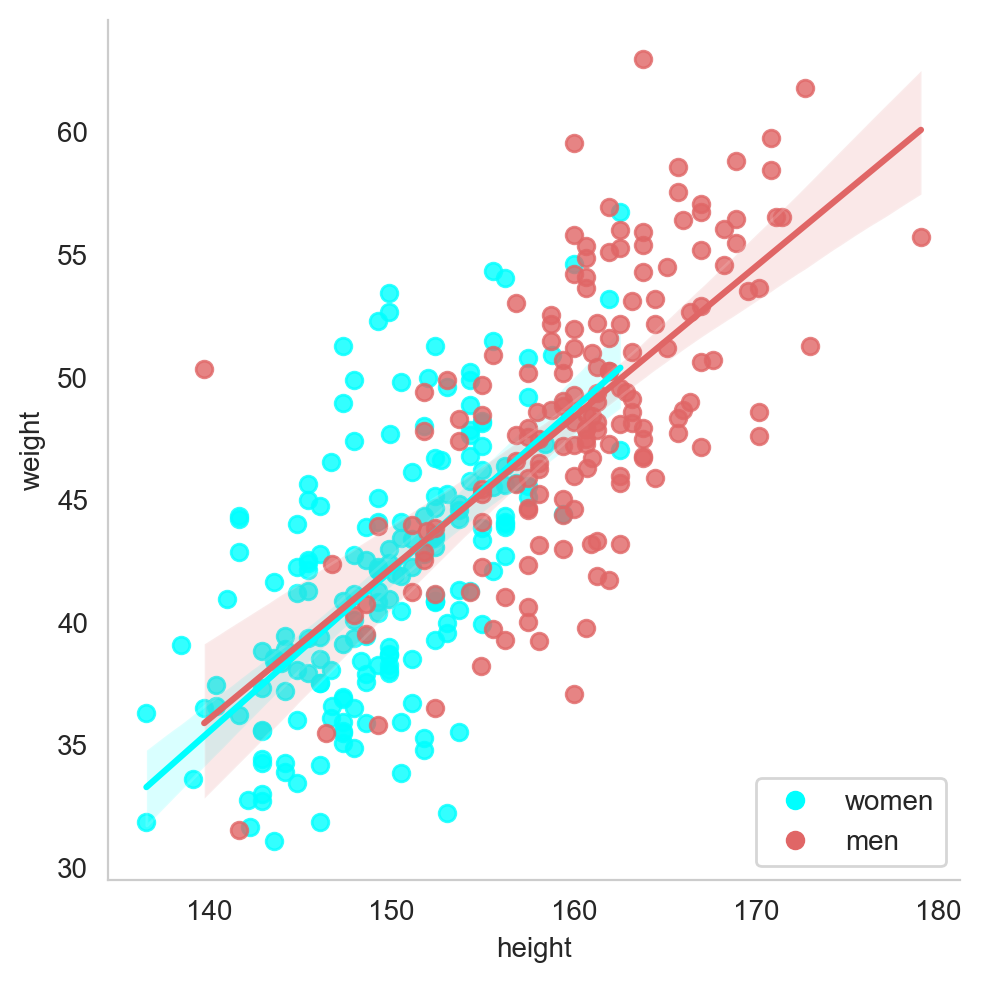

In [15]:
ax = sns.lmplot(data=df, x='height', y='weight', hue='male', palette=["cyan", "#e06666"], legend=False)

custom = [Line2D([], [], marker='o', color='cyan', linestyle='None'),
          Line2D([], [], marker='o', color='#e06666', linestyle='None')]

plt.legend(custom, ['women', 'men'], loc='lower right')
sns.despine()
plt.grid(False)

### Contrast at each height

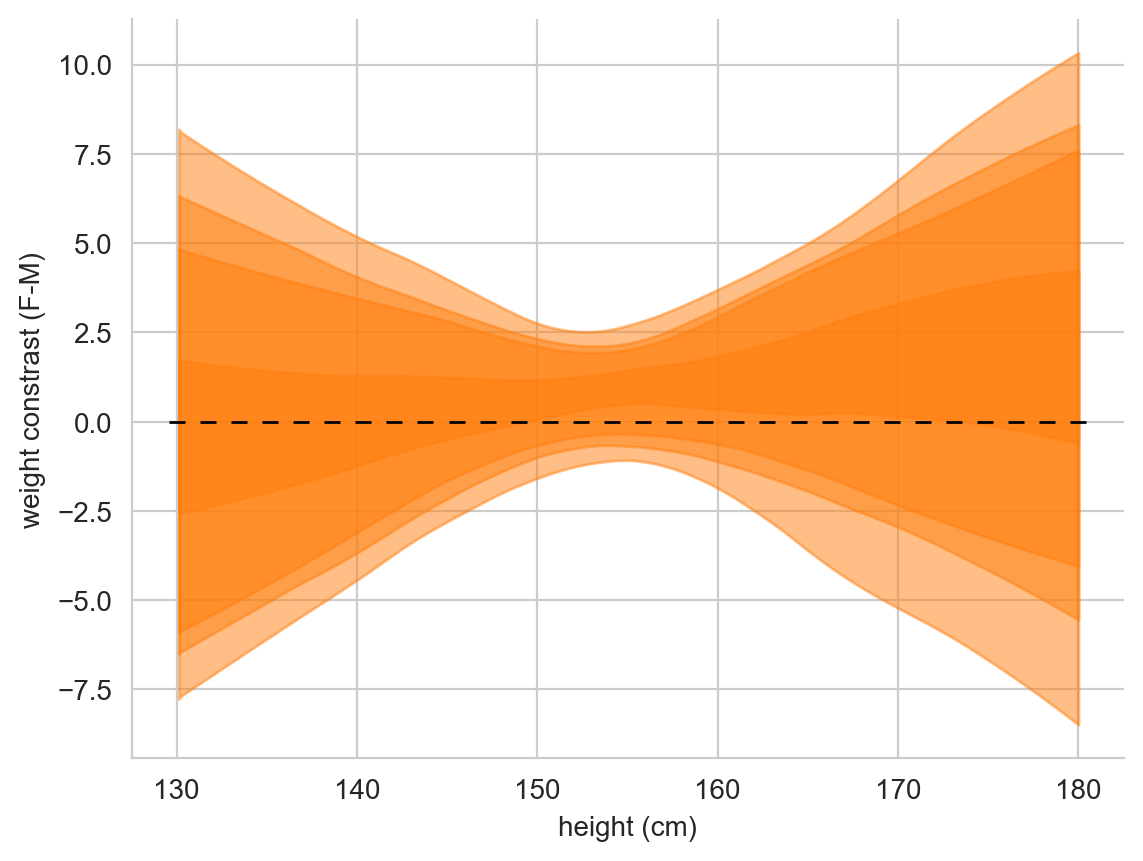

In [16]:
height_seq = np.linspace(130, 180, 30)

post_sample = az.extract(idata, num_samples=1000)
mu_pred_w = np.empty((len(height_seq), post_sample.sizes["sample"]))
mu_pred_m = np.empty((len(height_seq), post_sample.sizes["sample"]))

for i, ht in enumerate(height_seq):
    mu_pred_w[i] = post_sample.a.values[0] + post_sample.b.values[0] * (ht - df.height.mean())
    mu_pred_m[i] = post_sample.a.values[1] + post_sample.b.values[1] * (ht - df.height.mean())

mu_pred_contrast = mu_pred_w - mu_pred_m
j = 0

for p in [0.5, 0.9, 0.95, 0.99]:
    az.plot_hdi(height_seq, mu_pred_contrast.T, hdi_prob=p)

plt.plot(height_seq, [0] * len(height_seq), "_", color='k')
plt.xlabel("height (cm)")
plt.ylabel("weight constrast (F-M)")
sns.despine()

## Using a single model

In [17]:
H = df.height
W = df.weight
gen = df.male
H_bar = df.height.mean()

with pm.Model() as model:
    # weight model
    a = pm.Normal('a', 60, 10, shape=2)
    b = pm.Lognormal('b', 0, 2, shape=2)
    mu = pm.Deterministic('mu', a[gen] + b[gen] * (H - H_bar))
    sigma = pm.Uniform('sigma', 0, 10)
    
    weight = pm.Normal('weight', mu, sigma, observed=W)
    
    # height model
    a_h = pm.Normal('a_h', 160, 10, shape=2)
    mu_h = pm.Deterministic('mu_h', a_h[gen])
    sigma_h = pm.Uniform('sigma_h', 0, 10)
    
    height = pm.Normal("height", mu_h, sigma_h, observed=H)
    
    idata, _ = quap([a, b, a_h, sigma, sigma_h])

In [18]:
az.summary(idata, kind='stats')

,mean,sd,hdi_3%,hdi_97%
a[0],45.153,0.439,44.325,45.965
a[1],45.103,0.458,44.231,45.945
b[0],0.655,0.094,0.487,0.837
b[1],0.608,0.091,0.436,0.777
a_h[0],149.530,0.399,148.789,150.282
a_h[1],160.364,0.429,159.558,161.179
sigma,4.228,0.066,4.108,4.354
sigma_h,5.521,0.084,5.367,5.685


### Simulating interventions
Causal effect is consequence of intervention

In [19]:
post = az.extract(idata)
h_bar = df.height.mean()
n = int(1e4)

# simulating height and weight as if all samples are female
h_w = stats.norm.rvs(post.a_h.values[0], post.sigma_h.values, size=n)
mu_w = post.a.values[0] + post.b.values[0] * (h_w - h_bar)
w_w = stats.norm.rvs(mu_w, post.sigma.values, size = n)

# simulating height and weight as if all samples are male
h_m = stats.norm.rvs(post.a_h.values[1], post.sigma_h.values, size=n)
mu_m = post.a.values[1] + post.b.values[1] * (h_m - h_bar)
w_m = stats.norm.rvs(mu_m, post.sigma.values, size=n)

# contrast between posterior weights based on simulating interventions
w_do_G = w_m - w_w

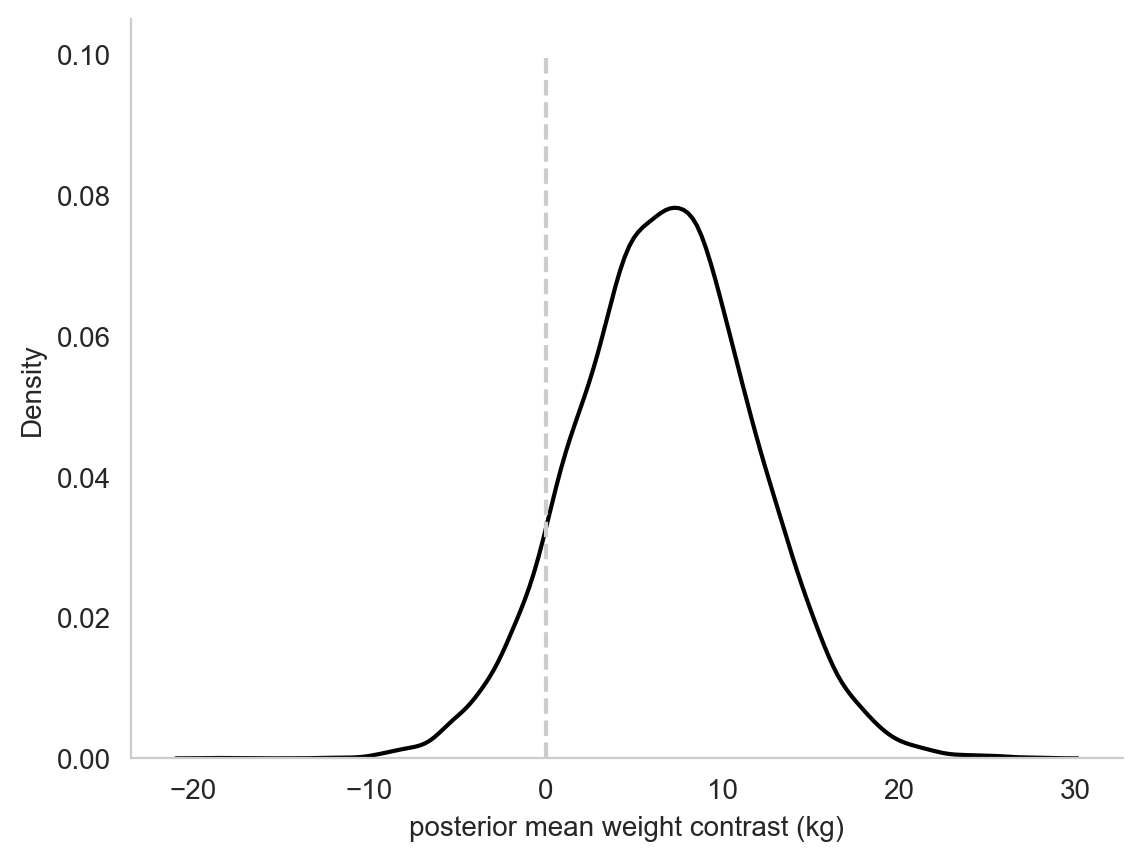

In [20]:
mu_contrast = mu_m - mu_w
sns.kdeplot(mu_contrast, color='k')
plt.xlabel("posterior mean weight contrast (kg)")
plt.vlines(0, 0, 0.1, color='#cccccc', linestyle='--')
sns.despine()
plt.grid(False)

[0.1922,0.8078]


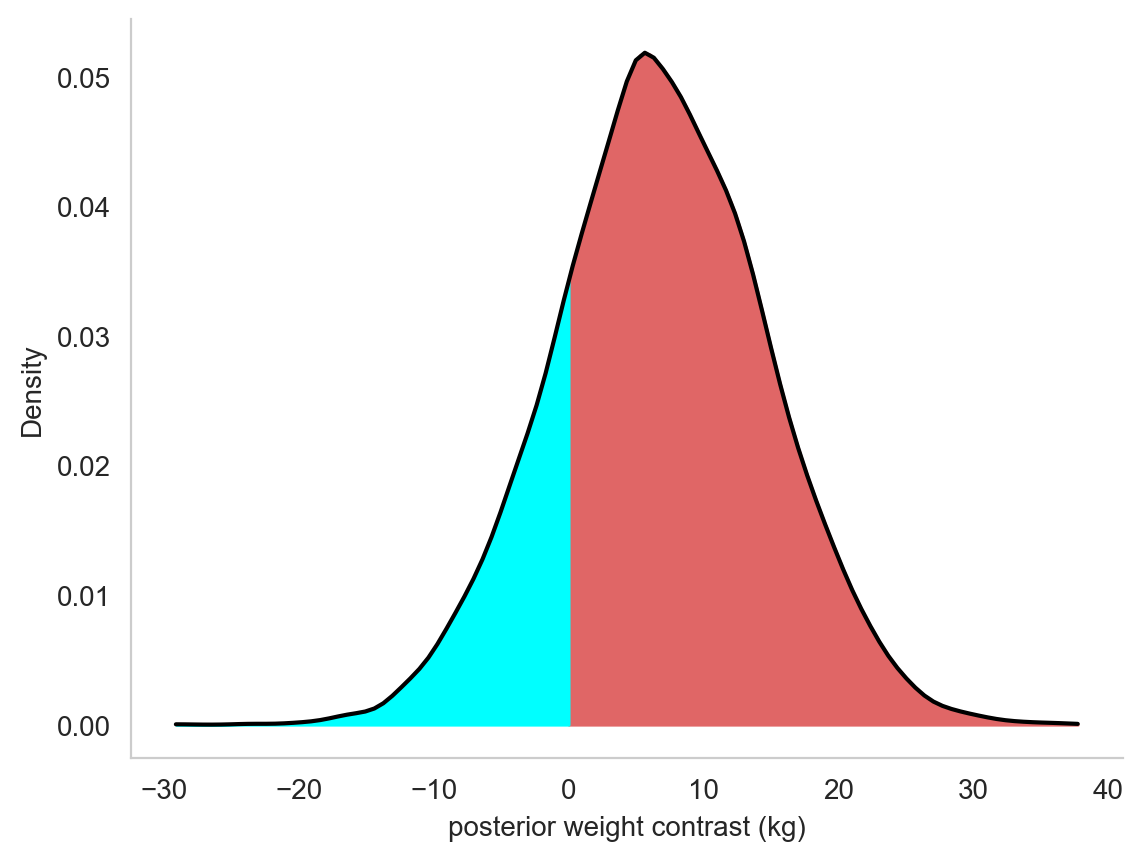

In [21]:
filled_contrast_dist(w_do_G)